In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import math
from numpy.linalg import norm
%matplotlib inline

In [4]:
data = pd.read_csv('./data/winequality-red.csv', sep=',')
data = data.drop_duplicates()
# copy the data
data_scaled = data.copy()
mean_data = data_scaled.mean()
std_data =  data_scaled.std()

# apply normalization techniques
for column in data_scaled.columns:
    if column!='MEDV':
        data_scaled[column] = (data_scaled[column] - mean_data[column]) / std_data[column]
    else : data_scaled[column] = (data_scaled[column] - mean_data[column]) / std_data[column]


df_label = data_scaled['quality']
df_features = data_scaled.drop(columns=['quality']) 

X_train, X_test, y_train, y_test = train_test_split(df_features, df_label, test_size=0.33, random_state=42, shuffle = True)

A_test = X_test.to_numpy() #training matrix
Y_test = y_test.to_numpy() #label matrix
A_train = X_train.to_numpy() #training matrix
Y_train = y_train.to_numpy() #label matrix
p = X_train.shape[1] #number of feature
n = X_train.shape[0] #nb of data point
#x0 = np.random.rand(p).T #random initial point 
x0 = np.zeros((p))

In [14]:
def gradient_descent(x0, A, y, iterations = 60, learning_rate = 0.66, stopping_threshold = 1e-6):

    # Initializing learning rate and iterations
    loss = [] #to return 
    past_x = [] #to return
    previous_loss = None
    vector=x0 #starting point
    n = X_train.shape[0] #nb of data point
    # Estimation of optimal parameters
    for _ in range(iterations):
        # Calculating a new prediction
        prediction = A.dot(vector)
        #mean square error
        error = y - prediction 
        mse = (1/(2*n))*(np.dot(error.T,error))
        loss.append(mse)
        # If the change in cost is less than or equal to stopping_threshold we stop the gradient 
        #print(mse)
        #if previous_loss and abs(previous_loss-mse)<=stopping_threshold:
        #     break

        #calcultating gradient
        grad = -(A.transpose().dot(error))/n

        #gradient descent step
        vector = vector - (learning_rate * grad)

        previous_loss = mse
        # Printing the mse for each iteration
        #print(f"Iteration {i+1}: Cost {mse}")

    return vector, loss

In [8]:
def block_coordinate_descent(x0, A, y,nblocks=1, iterations = 60):
    #  Inputs:
    #         x0: Initial point
    #         A: Data matrix
    #         y: Data vector
    #         nblocks: Number of coordinates drawn at every iteration
    #         iterations: Maximum number of iterations
 
    #Output : 
    #         x_output: Last iterate
    #         loss: History of function values (Numpy array of length at most nits)
    #         nnzvals: History of iterate sparsity (Numpy array of length at most nits)
 
    
    # Initializing learning rate and iterations
    loss = [] #to return 
    nnzvals = []

    vector=x0.copy() #starting point
    n,p = A.shape #nb of data point #number of feature
    # Lipschitz constants
    ell = norm(np.matmul(A.T,A),axis=0)
    prediction = A.dot(vector)
    error = y - prediction
    mse = (1/(2*n))*(np.dot(error.T,error))
    loss.append(mse)
    # Number of nonzero coefficients
    nnzvals.append(np.count_nonzero(vector))
    # Gradient for the smooth part of the objective
    g = A.T.dot(A.dot(vector) - y) / n


    # Estimation of optimal parameters
    for _ in range(iterations):
        jk = np.random.choice(p,nblocks,replace=False) # Uniform draw without replacement

        # Compute the new iterate by changing only one component
        for j in jk:
            vector[j] = vector[j]-(1/ell[j])*g[j]
            
        # Objective, sparsity level and gradient at the new point
        prediction = A.dot(vector)
        error = y - prediction
        mse = (1/(2*n))*(np.dot(error.T,error))
        loss.append(mse)
        nnzvals.append(np.count_nonzero(vector))
        g = A.T.dot(A.dot(vector) - y) / n
        x_output = vector.copy()
        
    return x_output, np.array(loss), np.array(nnzvals)

In [5]:
n,d = A_train.shape

Number of coordinate(s)/it: 1
Objective value: 2.2963006159176587
Number of coordinate(s)/it: 2
Objective value: 1.2460738434311336
Number of coordinate(s)/it: 5
Objective value: 0.5686857510150274
Number of coordinate(s)/it: 11
Objective value: 0.36673237442942475


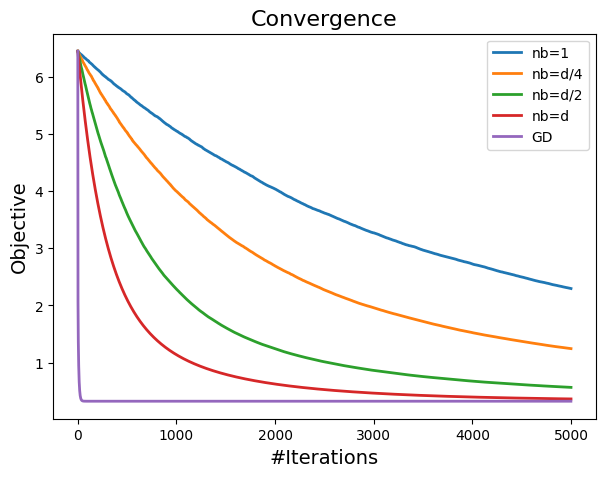

In [22]:
################# Test several block values

n,d = A_train.shape

nb=1
nits=5000
x0 = np.ones(d)

nb=1
x1,obj1,nnz1 = block_coordinate_descent(x0,A_train,Y_train,nb,nits)
print('Number of coordinate(s)/it:',nb)
print('Objective value:',obj1[-1])


nb=int(d/4)
x2,obj2,nnz2 = block_coordinate_descent(x0,A_train,Y_train,nb,nits)
print('Number of coordinate(s)/it:',nb)
print('Objective value:',obj2[-1])


nb=int(d/2)
x3,obj3,nnz3 = block_coordinate_descent(x0,A_train,Y_train,nb,nits)
print('Number of coordinate(s)/it:',nb)
print('Objective value:',obj3[-1])


nb=d
x4,obj4,nnz4 = block_coordinate_descent(x0,A_train,Y_train,nb,nits)
print('Number of coordinate(s)/it:',nb)
print('Objective value:',obj4[-1])


x5, loss = gradient_descent(x0, A_train, Y_train, nits)


################# Plot the results across all iterations

# Evolution of the loss
plt.figure(figsize=(7, 5))
plt.plot(obj1, label="nb=1",lw=2)
plt.plot(obj2, label="nb=d/4", lw=2)
plt.plot(obj3, label="nb=d/2", lw=2)
plt.plot(obj4, label="nb=d", lw=2)
plt.plot(loss, label="GD", lw=2)
plt.title("Convergence", fontsize=16)
plt.xlabel("#Iterations", fontsize=14)
plt.ylabel("Objective", fontsize=14)
plt.legend()

In [20]:
def coordinate_descent(x0, A, y, iterations = 60, learning_rate = 0.01, stopping_threshold = 1e-6):

    # Initializing learning rate and iterations
    loss = [] #to return 
    vector=x0.copy() #starting point
    n,p = A.shape #nb of data point #number of feature
    # Estimation of optimal parameters
    for _ in range(iterations):
        for i in range(p):
            # Calculating a new prediction
            prediction = A.dot(vector)
            #mean square error
            error = y - prediction 
            #calcultating gradient
            grad = -(A[:,i].transpose().dot(error))/n 

            #gradient descent step
            vector[i] = vector[i] - (learning_rate * grad)
            
        error = y - A.dot(vector)
        mse = (1/(2*n))*(np.dot(error.T,error))
        loss.append(mse)

    return vector, loss

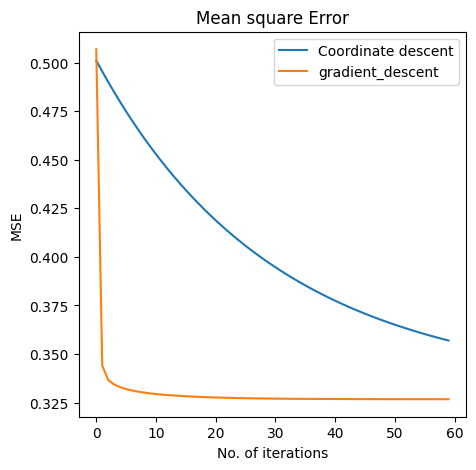

In [21]:
plt.figure(figsize=(5, 5))
x0 = np.zeros((p))

final_x , loss = coordinate_descent(x0, A_train , Y_train)
plt.plot(loss, label='Full batch Coordinate descent')
final_x , loss = gradient_descent(x0, A_train , Y_train)
plt.plot(loss, label='gradient_descent')
plt.title('Convergence')
plt.xlabel('No. of iterations')
plt.ylabel('Objective')
plt.legend()
plt.show()

Looking to the result above, it seems that Coordinate gradient is not beneficial on my case, but it could finally converge to the gradient descent solution

### Question 2

In [16]:
def Coordinate_SGD(x0, A, y, nb_epochs = 60, nb=1 ,learning_rate = 0.01, stopping_threshold = 1e-6):
    # Initializing learning rate and iterations
    loss = [] #to return 
    vector=x0.copy() #starting point
    n,p = A.shape #nb of data point
    # Estimation of optimal parameters
    for k in range(int(nb_epochs*n/nb)):
        #random value in train
        ik = [int(el) for el in np.floor(np.random.rand(nb)*n)]
        # Calculating a new prediction
        prediction = A[ik,].dot(vector)
        #mean square error
        error = y[ik] - prediction 
        for i in range(p):
            #calcultating gradient
            grad_k = -(A[ik,i].transpose().dot(error))/nb

            #gradient descent step
            vector[i] = vector[i] - (learning_rate * grad_k)
            
        if (k*nb) % n == 0:
            # Calculating a new prediction
            #prediction = A[ik,].dot(vector)
            #mean square error
            #error = y - prediction 
            mse = 1/(2*nb) *(np.dot(error.T,error))
            loss.append(mse)

    return vector, loss

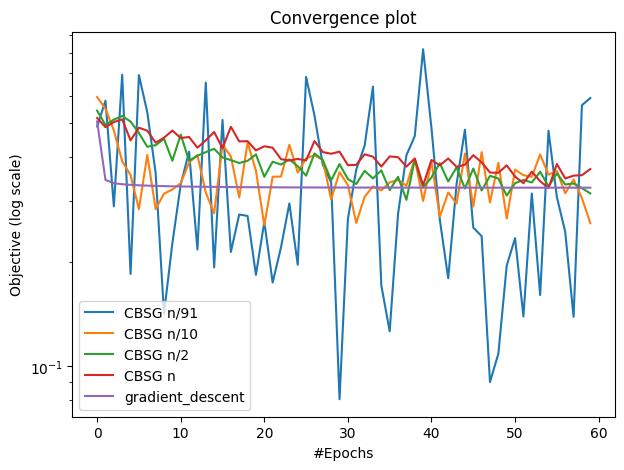

In [19]:
n,p = A_train.shape
x0 = np.zeros((p))


plt.figure(figsize=(7, 5))
final_x , loss = Coordinate_SGD(x0, A_train , Y_train, nb=int(n/91))
plt.semilogy(loss, label='CBSG ' + 'n/91')
final_x , loss = Coordinate_SGD(x0, A_train , Y_train, nb=int(n/10))
plt.semilogy(loss, label='CBSG ' + 'n/10')
final_x , loss = Coordinate_SGD(x0, A_train , Y_train, nb=int(n/2))
plt.semilogy(loss, label='CBSG ' + 'n/2')
final_x , loss = Coordinate_SGD(x0, A_train , Y_train, nb=int(n))
plt.semilogy(loss, label='CBSG ' + 'n')
final_x , loss = gradient_descent(x0, A_train , Y_train)
plt.semilogy(loss, label='gradient_descent')
plt.title('Convergence plot')
plt.xlabel('#Epochs')
plt.ylabel('Objective (log scale)')
plt.legend()
plt.show()